##  Project – The Battle of Neighborhoods | Finding a Better Place in North York, Toronto

### <b>installing libraries</b>

In [1]:
!pip install geocoder
!pip install folium

     |████████████████████████████████| 102kB 8.5MB/s ta 0:00:011
     |████████████████████████████████| 102kB 8.9MB/s ta 0:00:011


In [2]:
import requests
import numpy as np
import pandas as pd
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup



print("All Required Libraries Imported!")

All Required Libraries Imported!


2. Data Extraction and Cleaning

### importig dataset and cleaning the dataset and placing it into dataframe

In [3]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

extracting_data = requests.get(url).text
wiki_data = BeautifulSoup(extracting_data, 'lxml')

In [56]:
column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

content = wiki_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']\n','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)
 #   print(toronto)

In [58]:
# clean dataframe 
toronto = toronto[toronto.Borough!='Not assigned\n']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)


i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned\n':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1

In [59]:
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()


,Postalcode,Borough,Neighborhood
0,M1B\n,Scarborough\n,"Malvern, Rouge"
1,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek"
2,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill"
3,M1G\n,Scarborough\n,Woburn
4,M1H\n,Scarborough\n,Cedarbrae


In [62]:
df.describe()

,Postalcode,Borough,Neighborhood
count,103,103,103
unique,103,10,98
top,M5S\n,North York\n,Downsview
freq,1,24,4


In [63]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]

In [64]:
df.head()

,Postalcode,Borough,Neighborhood
0,M1B\n,Scarborough\n,"Malvern, Rouge"
1,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek"
2,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill"
3,M1G\n,Scarborough\n,Woburn
4,M1H\n,Scarborough\n,Cedarbrae


In [34]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [35]:
df_2.describe()

,Postalcode,Borough,Neighborhood
count,103,103,103
unique,103,10,98
top,M5S\n,North York\n,Downsview
freq,1,24,4


In [36]:
print(df_2.shape)
df_2.head()

(103, 3)


,Postalcode,Borough,Neighborhood
0,M1B\n,Scarborough\n,"Malvern,Rouge"
1,M1C\n,Scarborough\n,"RougeHill,PortUnion,HighlandCreek"
2,M1E\n,Scarborough\n,"Guildwood,Morningside,WestHill"
3,M1G\n,Scarborough\n,Woburn
4,M1H\n,Scarborough\n,Cedarbrae


In [37]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4G')

[43.70941386000004, -79.36309957799995]

In [38]:
# Retrieving Postal Code Co-ordinates
postal_codes = df_2['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [39]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [65]:
df_2[df_2.Postalcode == 'M1H\n']

,Postalcode,Borough,Neighborhood,Latitude,Longitude
4,M1H\n,Scarborough\n,Cedarbrae,43.768791,-79.238813


In [66]:
df_2.head(10)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1B\n,Scarborough\n,"Malvern,Rouge",43.808626,-79.189913
1,M1C\n,Scarborough\n,"RougeHill,PortUnion,HighlandCreek",43.785779,-79.157368
2,M1E\n,Scarborough\n,"Guildwood,Morningside,WestHill",43.765806,-79.185284
3,M1G\n,Scarborough\n,Woburn,43.771545,-79.218135
4,M1H\n,Scarborough\n,Cedarbrae,43.768791,-79.238813
5,M1J\n,Scarborough\n,ScarboroughVillage,43.744203,-79.228725
6,M1K\n,Scarborough\n,"KennedyPark,Ionview,EastBirchmountPark",43.726881,-79.265694
7,M1L\n,Scarborough\n,"GoldenMile,Clairlea,Oakridge",43.713340,-79.284942
8,M1M\n,Scarborough\n,"Cliffside,Cliffcrest,ScarboroughVillageWest",43.723538,-79.228353
9,M1N\n,Scarborough\n,"BirchCliff,CliffsideWest",43.696448,-79.265642


### Map of North York

In [68]:
address = 'North York,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of North York,Toronto are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of North York,Toronto are 43.7543263, -79.44911696639593.


In [69]:
map_York = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_York)  
    
map_York

In [70]:
address = 'North York,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood_1 are 43.7543263, -79.44911696639593.


In [83]:
CLIENT_ID = 'YDMIQAULHSFC3KSENO44VI1XDT32TPG1SN3JMRIUTRQVRKRX' # my Foursquare ID
CLIENT_SECRET = 'AUACFZVYKCMJNDROB3CH1YJLYJCIFF3EYGS325B31E5TFBCR' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: YDMIQAULHSFC3KSENO44VI1XDT32TPG1SN3JMRIUTRQVRKRX
CLIENT_SECRET: AUACFZVYKCMJNDROB3CH1YJLYJCIFF3EYGS325B31E5TFBCR


In [84]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()
print(results)

{'meta': {'code': 200, 'requestId': '5ec264c4963d29001b1b5d55'}, 'response': {'headerLocation': 'Bathurst Manor', 'headerFullLocation': 'Bathurst Manor, Toronto', 'headerLocationGranularity': 'neighborhood', 'totalResults': 13, 'suggestedBounds': {'ne': {'lat': 43.76062630630001, 'lng': -79.44041124686424}, 'sw': {'lat': 43.74802629369999, 'lng': -79.45782268592762}}, 'groups': [{'type': 'Recommended Places', 'name': 'recommended', 'items': [{'reasons': {'count': 0, 'items': [{'summary': 'This spot is popular', 'type': 'general', 'reasonName': 'globalInteractionReason'}]}, 'venue': {'id': '5a888f7647f8767d37b92f00', 'name': 'Grill Gate', 'location': {'address': '832 Sheppard West', 'crossStreet': 'NE corner of Sheppard & Wilmington', 'lat': 43.753122978404804, 'lng': -79.45169001817703, 'labeledLatLngs': [{'label': 'display', 'lat': 43.753122978404804, 'lng': -79.45169001817703}], 'distance': 246, 'postalCode': 'M3H 2T1', 'cc': 'CA', 'neighborhood': 'Bathurst Manor', 'city': 'North Yor

In [97]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.id', 'venue.location.address', 'venue.location.cc',
       'venue.location.city', 'venue.location.country',
       'venue.location.crossStreet', 'venue.location.distance',
       'venue.location.formattedAddress', 'venue.location.labeledLatLngs',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.neighborhood', 'venue.location.postalCode',
       'venue.location.state', 'venue.name', 'venue.photos.count',
       'venue.photos.groups'],
      dtype='object')

In [98]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Locations and venues in the vicinity

In [99]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Grill Gate,"[{'id': '4bf58dd8d48988d1c0941735', 'name': 'M...",43.753123,-79.451690
1,Wolfie's Deli,"[{'id': '4bf58dd8d48988d146941735', 'name': 'D...",43.754875,-79.442438
2,Orly Restaurant & Grill,"[{'id': '4bf58dd8d48988d115941735', 'name': 'M...",43.754493,-79.443507
3,Tim Hortons,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.754767,-79.443250
4,Bagel Plus,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",43.755395,-79.440686


### venue by category

In [100]:

nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,Grill Gate,Mediterranean Restaurant,43.753123,-79.451690
1,Wolfie's Deli,Deli / Bodega,43.754875,-79.442438
2,Orly Restaurant & Grill,Middle Eastern Restaurant,43.754493,-79.443507
3,Tim Hortons,Coffee Shop,43.754767,-79.443250
4,Bagel Plus,Restaurant,43.755395,-79.440686


In [101]:
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Pizza Place                  3
Coffee Shop                  1
Men's Store                  1
Deli / Bodega                1
American Restaurant          1
Mediterranean Restaurant     1
Fried Chicken Joint          1
Sushi Restaurant             1
Video Store                  1
Middle Eastern Restaurant    1
Name: categories, dtype: int64

In [102]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [103]:
north_york_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Malvern,Rouge
RougeHill,PortUnion,HighlandCreek
Guildwood,Morningside,WestHill
Woburn
Cedarbrae
ScarboroughVillage
KennedyPark,Ionview,EastBirchmountPark
GoldenMile,Clairlea,Oakridge
Cliffside,Cliffcrest,ScarboroughVillageWest
BirchCliff,CliffsideWest
DorsetPark,WexfordHeights,ScarboroughTownCentre
Wexford,Maryvale
Agincourt
ClarksCorners,TamO'Shanter,Sullivan
Milliken,AgincourtNorth,SteelesEast,L'AmoreauxEast
SteelesWest,L'AmoreauxWest
UpperRouge
HillcrestVillage
Fairview,HenryFarm,Oriole
BayviewVillage
YorkMills,SilverHills
Willowdale,Newtonbrook
Willowdale
YorkMillsWest
Willowdale
Parkwoods
DonMills
DonMills
BathurstManor,WilsonHeights,DownsviewNorth
NorthwoodPark,YorkUniversity
Downsview
Downsview
Downsview
Downsview
VictoriaVillage
ParkviewHill,WoodbineGardens
WoodbineHeights
TheBeaches
Leaside
ThorncliffePark
EastToronto
TheDanforthWest,Riverdale
IndiaBazaar,TheBeachesWest
StudioDistrict
LawrencePark
DavisvilleNorth
NorthTorontoWest
Davisville
MoorePark,SummerhillEast
SummerhillW

In [106]:
print('There are {} Uniques Categories.'.format(len(north_york_venues['Venue Category'].unique())))
north_york_venues.groupby('Neighborhood').count().head()

There are 310 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,28,28,28,28,28,28
"Alderwood,LongBranch",9,9,9,9,9,9
"BathurstManor,WilsonHeights,DownsviewNorth",24,24,24,24,24,24
BayviewVillage,4,4,4,4,4,4
"BedfordPark,LawrenceManorEast",24,24,24,24,24,24


### Hot Encoding

In [108]:
# one hot encoding
north_york_onehot = pd.get_dummies(north_york_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
north_york_onehot['Neighborhood'] = north_york_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [north_york_onehot.columns[-1]] + list(north_york_onehot.columns[:-1])
north_york_onehot = north_york_onehot[fixed_columns]
north_york_grouped = north_york_onehot.groupby('Neighborhood').mean().reset_index()
north_york_onehot.head()

,Yoga Studio,ATM,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Antique Shop,Aquarium,Arcade,...,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
num_top_venues = 5
for hood in north_york_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =north_york_grouped[north_york_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
                 venue  freq
0        Shopping Mall  0.11
1   Chinese Restaurant  0.07
2  Filipino Restaurant  0.04
3     Malay Restaurant  0.04
4               Lounge  0.04


---- Alderwood,LongBranch ----
               venue  freq
0               Pool  0.11
1  Convenience Store  0.11
2        Pizza Place  0.11
3                Pub  0.11
4        Gas Station  0.11


---- BathurstManor,WilsonHeights,DownsviewNorth ----
                 venue  freq
0                 Bank  0.08
1          Coffee Shop  0.08
2                 Park  0.08
3  Fried Chicken Joint  0.04
4                Trail  0.04


---- BayviewVillage ----
          venue  freq
0          Park  0.50
1   Flower Shop  0.25
2         Trail  0.25
3        Office  0.00
4  Noodle House  0.00


---- BedfordPark,LawrenceManorEast ----
                     venue  freq
0       Italian Restaurant  0.12
1           Sandwich Place  0.08
2              Coffee Shop  0.08
3  Comfort Food Restaurant  0.04
4               

### most common venues in the neighbourhood

In [110]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [112]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = north_york_grouped['Neighborhood']

for ind in np.arange(north_york_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(north_york_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Shopping Mall,Chinese Restaurant,Lounge,Asian Restaurant,Motorcycle Shop,Supermarket,Sushi Restaurant,Café,Dim Sum Restaurant,Latin American Restaurant
1,"Alderwood,LongBranch",Pizza Place,Skating Rink,Sandwich Place,Convenience Store,Pub,Gym,Coffee Shop,Pool,Gas Station,Eastern European Restaurant
2,"BathurstManor,WilsonHeights,DownsviewNorth",Bank,Park,Coffee Shop,Middle Eastern Restaurant,Diner,Fried Chicken Joint,Restaurant,Gas Station,Deli / Bodega,Sandwich Place
3,BayviewVillage,Park,Flower Shop,Trail,Women's Store,Eastern European Restaurant,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
4,"BedfordPark,LawrenceManorEast",Italian Restaurant,Sandwich Place,Coffee Shop,Pet Store,Butcher,Juice Bar,Restaurant,Café,Sports Club,Thai Restaurant


### k-means with k=3

In [116]:
# Using K-Means to cluster neighborhood into 3 clusters
north_york_grouped_clustering = north_york_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(north_york_grouped_clustering)
kmeans.labels_

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1], dtype=int32)

In [117]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

north_york_merged =df_2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
north_york_merged = north_york_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

north_york_merged.head()# check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B\n,Scarborough\n,"Malvern,Rouge",43.808626,-79.189913,1,Park,Trail,Women's Store,Diner,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
1,M1C\n,Scarborough\n,"RougeHill,PortUnion,HighlandCreek",43.785779,-79.157368,1,Fish & Chips Shop,Park,Bar,Moving Target,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Ethiopian Restaurant,Electronics Store
2,M1E\n,Scarborough\n,"Guildwood,Morningside,WestHill",43.765806,-79.185284,0,Pizza Place,Park,Coffee Shop,Greek Restaurant,Fast Food Restaurant,Bank,Medical Center,Supermarket,Beer Store,Food & Drink Shop
3,M1G\n,Scarborough\n,Woburn,43.771545,-79.218135,0,Coffee Shop,Business Service,Park,Women's Store,Electronics Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
4,M1H\n,Scarborough\n,Cedarbrae,43.768791,-79.238813,0,Thai Restaurant,Gas Station,Hakka Restaurant,Athletics & Sports,Lounge,Bank,Women's Store,Dumpling Restaurant,Dive Bar,Dog Run


### map

In [137]:
kclusters = 10

In [138]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(north_york_merged['Latitude'], 
                                   north_york_merged['Longitude'], 
                                   north_york_merged['Neighborhood'], 
                                   north_york_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [120]:
df1=north_york_merged.loc[north_york_merged['Cluster Labels'] == 0,north_york_merged.columns[[2] + list(range(5, north_york_merged.shape[1]))]]
df2=north_york_merged.loc[north_york_merged['Cluster Labels'] == 1,north_york_merged.columns[[2] + list(range(5, north_york_merged.shape[1]))]]
df3=north_york_merged.loc[north_york_merged['Cluster Labels'] == 2,north_york_merged.columns[[2] + list(range(5, north_york_merged.shape[1]))]]

In [121]:
north_york_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})

### Avg Housing prices 

In [122]:
north_york_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

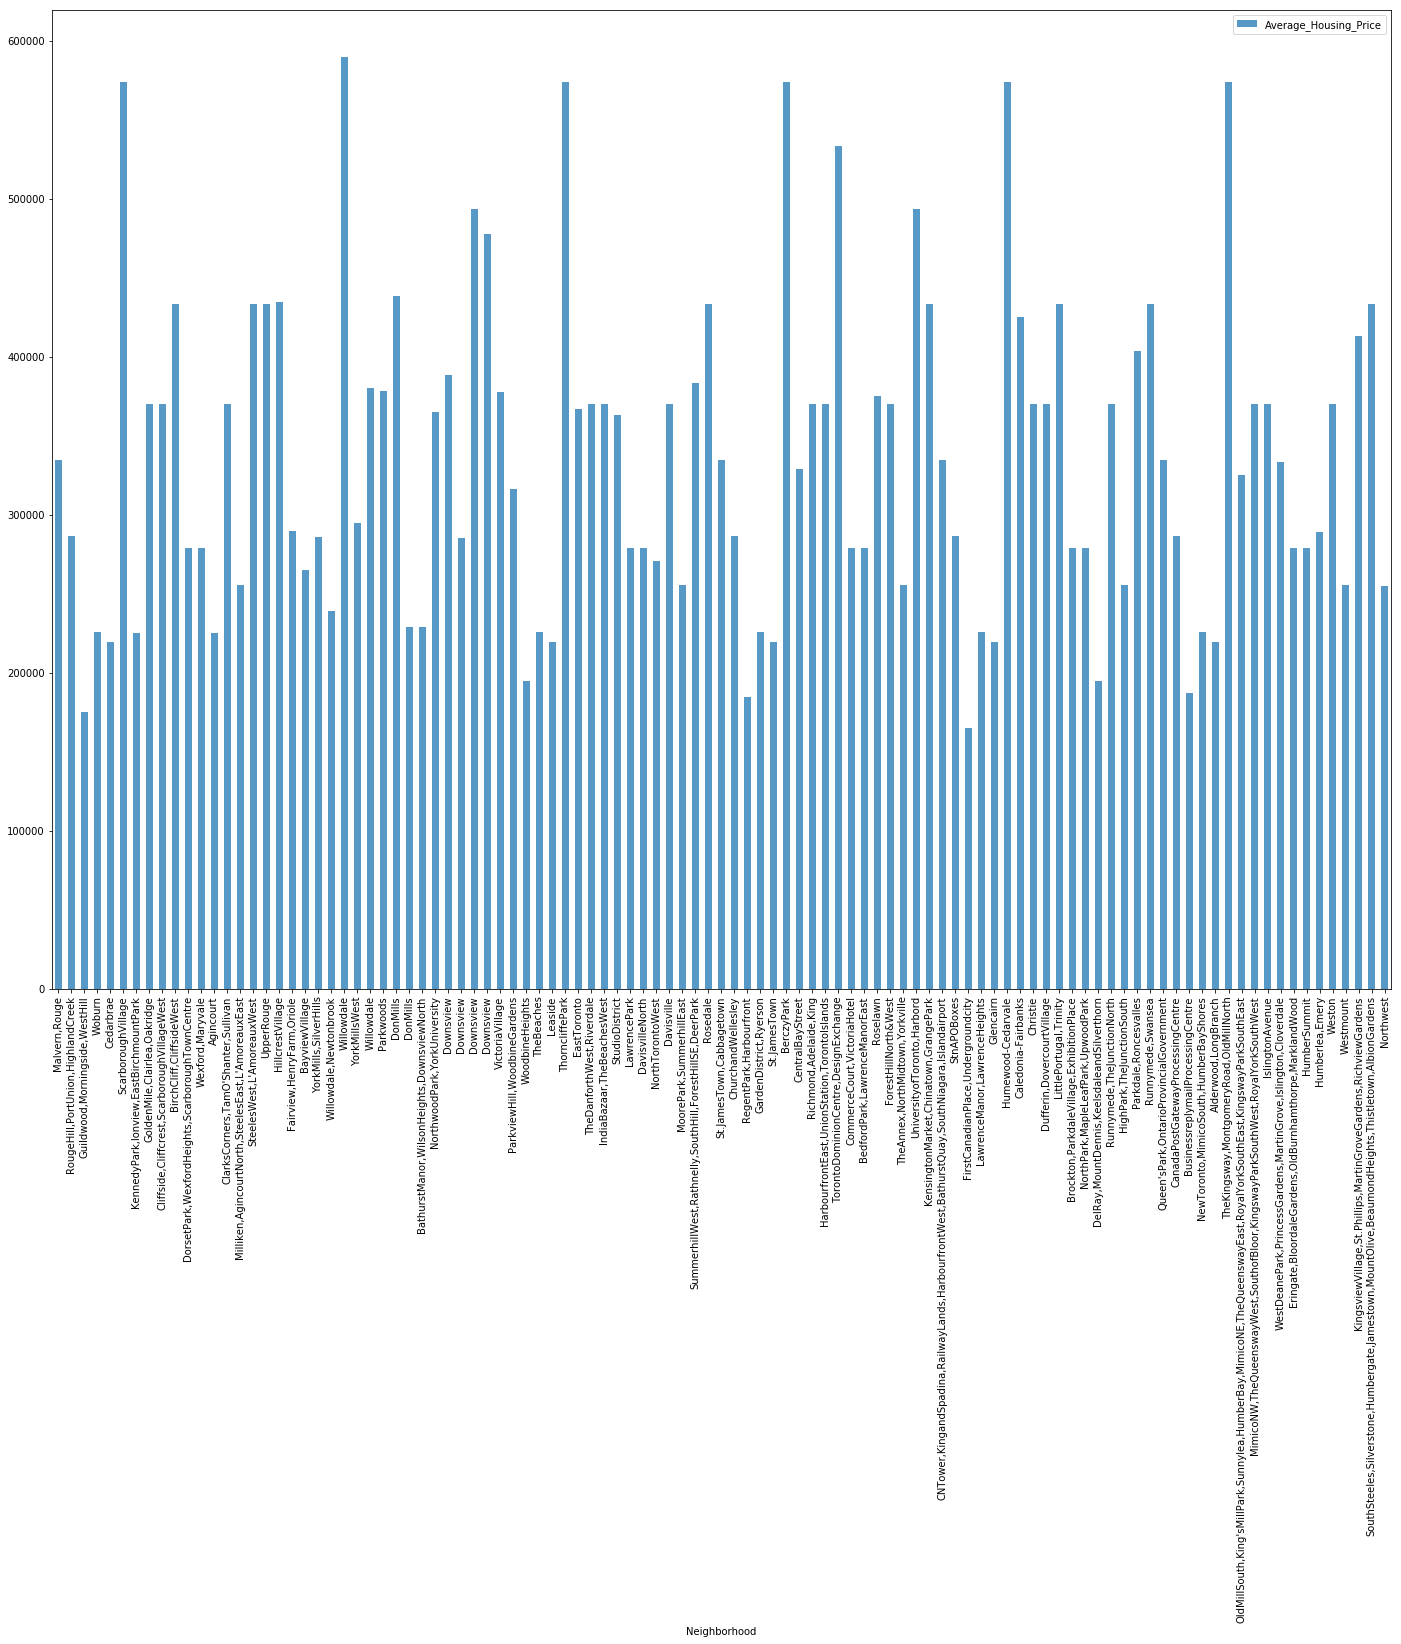

In [123]:
north_york_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

### Avg School ratings

In [139]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [126]:
new_north_york=north_york_merged.set_index("Neighborhood",drop=True)
#Source:https://www.greatschools.org
north_york_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

In [127]:
north_york_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

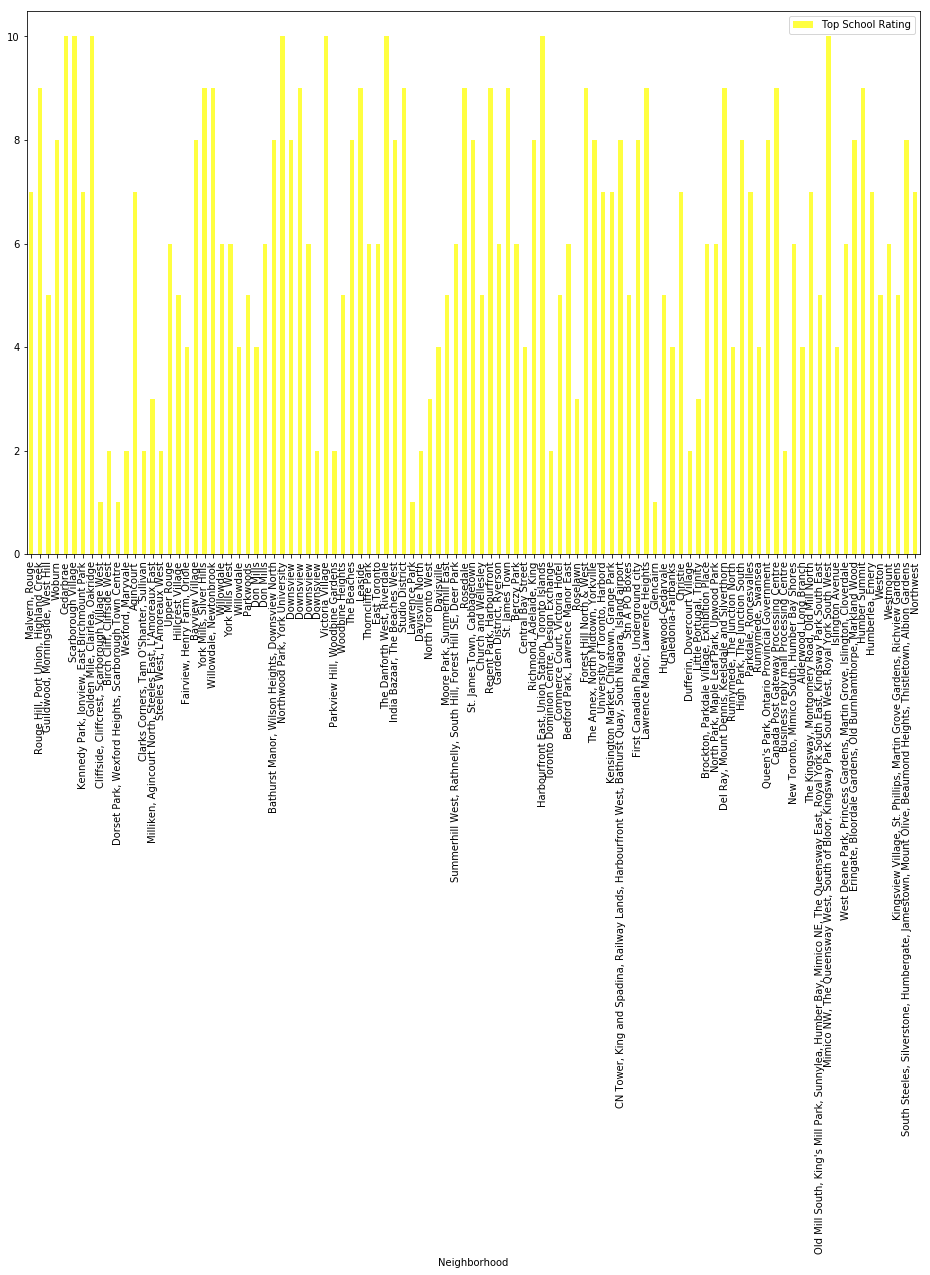

In [129]:
north_york_school_ratings.plot(kind='bar',figsize=(16,10),color='yellow',alpha=0.75);

### Thus,particular neighborhood prediction based on average house prices and school rating have been made.